<a href="https://colab.research.google.com/github/tanvimathur11/DDA/blob/main/DDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Distributed Data Analysis

### 1. Import Libraries

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#importing neccesary libraries for the Notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy
from sqlalchemy import text
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
import pyspark
from pyspark.sql import SparkSession
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

### 1.1 Loading Dataset to Dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/train.csv',low_memory=False)
dataset.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

In [ ]:
#dropping features which are not useful for determining the credit score

initial_dataset = dataset.drop(["Amount_invested_monthly", "SSN", "Name", "Month", "Age", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Type_of_Loan", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Credit_Mix", "Credit_Utilization_Ratio"], axis=1)

In [ ]:
initial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      100000 non-null  object 
 1   Customer_ID             100000 non-null  object 
 2   Occupation              100000 non-null  object 
 3   Annual_Income           100000 non-null  object 
 4   Monthly_Inhand_Salary   84998 non-null   float64
 5   Num_of_Loan             100000 non-null  object 
 6   Delay_from_due_date     100000 non-null  int64  
 7   Num_of_Delayed_Payment  92998 non-null   object 
 8   Outstanding_Debt        100000 non-null  object 
 9   Credit_History_Age      90970 non-null   object 
 10  Payment_of_Min_Amount   100000 non-null  object 
 11  Total_EMI_per_month     100000 non-null  float64
 12  Payment_Behaviour       100000 non-null  object 
 13  Monthly_Balance         98800 non-null   object 
 14  Credit_Score         

In [ ]:
initial_dataset.to_csv('final_dataset.csv', index=False)

In [ ]:
initial_dataset.head()

,ID,Customer_ID,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,Scientist,19114.12,1824.843333,4,3,7,809.98,22 Years and 1 Months,No,49.574949,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,Scientist,19114.12,NaN,4,-1,NaN,809.98,NaN,No,49.574949,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,Scientist,19114.12,NaN,4,3,7,809.98,22 Years and 3 Months,No,49.574949,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,Scientist,19114.12,NaN,4,5,4,809.98,22 Years and 4 Months,No,49.574949,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,Scientist,19114.12,1824.843333,4,6,NaN,809.98,22 Years and 5 Months,No,49.574949,High_spent_Medium_value_payments,341.48923103222177,Good


In [ ]:
initial_dataset.shape

(100000, 15)

## 2. Data Preparation and Cleaning

In this section we will work on analysing the data for the Missing values, Inconsistencies, Data Imputation. This is to prepare the Data for further processing such as EDA & Modeling

In [ ]:
initial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      100000 non-null  object 
 1   Customer_ID             100000 non-null  object 
 2   Occupation              100000 non-null  object 
 3   Annual_Income           100000 non-null  object 
 4   Monthly_Inhand_Salary   84998 non-null   float64
 5   Num_of_Loan             100000 non-null  object 
 6   Delay_from_due_date     100000 non-null  int64  
 7   Num_of_Delayed_Payment  92998 non-null   object 
 8   Outstanding_Debt        100000 non-null  object 
 9   Credit_History_Age      90970 non-null   object 
 10  Payment_of_Min_Amount   100000 non-null  object 
 11  Total_EMI_per_month     100000 non-null  float64
 12  Payment_Behaviour       100000 non-null  object 
 13  Monthly_Balance         98800 non-null   object 
 14  Credit_Score         

### 2.1 Dealing with Missing Values and Special Characters

### 2.1.1 Dealing with the missing values of Monthly_Inhand_Salary columns

In [ ]:
grouped_df = initial_dataset.groupby("Customer_ID")

In [ ]:
print(grouped_df["Monthly_Inhand_Salary"].count())

Customer_ID
CUS_0x1000    7
CUS_0x1009    8
CUS_0x100b    7
CUS_0x1011    7
CUS_0x1013    5
             ..
CUS_0xff3     7
CUS_0xff4     7
CUS_0xff6     8
CUS_0xffc     8
CUS_0xffd     7
Name: Monthly_Inhand_Salary, Length: 12500, dtype: int64


In [ ]:
# Convert the Customer_ID column to a factor/category
initial_dataset['Customer_ID'] = initial_dataset['Customer_ID'].astype('category')

# Calculate the median Inhand Salary by customer using groupby and summarize
median_Inhand_salary_by_customer = initial_dataset.groupby('Customer_ID').agg(median_salary=('Monthly_Inhand_Salary', 'median'))

# Join the median salary column to the dataset
initial_dataset = pd.merge(initial_dataset, median_Inhand_salary_by_customer, on='Customer_ID', how='left')

# Replace missing values in Monthly Inhand Salary column with median salary
initial_dataset['Monthly_Inhand_Salary'].fillna(initial_dataset['median_salary'], inplace=True)

# Drop the median salary column
initial_dataset.drop('median_salary', axis=1, inplace=True)


In [ ]:
median_Inhand_salary_by_customer

,median_salary
Customer_ID,
CUS_0x1000,2706.161667
CUS_0x1009,4250.390000
CUS_0x100b,9549.782500
CUS_0x1011,5208.872500
CUS_0x1013,7962.415000
...,...
CUS_0xff3,1176.398750
CUS_0xff4,2415.855000
CUS_0xff6,9727.326667


In [ ]:
initial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      100000 non-null  object  
 1   Customer_ID             100000 non-null  category
 2   Occupation              100000 non-null  object  
 3   Annual_Income           100000 non-null  object  
 4   Monthly_Inhand_Salary   100000 non-null  float64 
 5   Num_of_Loan             100000 non-null  object  
 6   Delay_from_due_date     100000 non-null  int64   
 7   Num_of_Delayed_Payment  92998 non-null   object  
 8   Outstanding_Debt        100000 non-null  object  
 9   Credit_History_Age      90970 non-null   object  
 10  Payment_of_Min_Amount   100000 non-null  object  
 11  Total_EMI_per_month     100000 non-null  float64 
 12  Payment_Behaviour       100000 non-null  object  
 13  Monthly_Balance         98800 non-null   object  
 14  Credi

**Observation**
* Totally 15002 entries has null values for the Monthly_Inhand_Salary
* Out of 100000 , we have 12500 Unique Customer_ID
* To handle the Missing Values for the 15002 Entries we imputed it with the Median_Values based on each Customer_ID

### 2.1.2 Deal with the missing values and '_' of Num_of_Delayed_Payment 

In [ ]:
initial_dataset["Num_of_Delayed_Payment"].describe()

count     92998
unique      749
top          19
freq       5327
Name: Num_of_Delayed_Payment, dtype: object

In [ ]:
# replace the '_' with ''
initial_dataset['Num_of_Delayed_Payment'] = initial_dataset['Num_of_Delayed_Payment'].replace('_', '', regex=True)

# convert to numeric
initial_dataset['Num_of_Delayed_Payment'] = initial_dataset['Num_of_Delayed_Payment'].astype(float)

In [ ]:
initial_dataset["Num_of_Delayed_Payment"].describe()

count    92998.000000
mean        30.923342
std        226.031892
min         -3.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4397.000000
Name: Num_of_Delayed_Payment, dtype: float64

In [ ]:
#Changing the Negative Values in the Num_of_Delayed_Payemnts to '0' as it cannot be negative
initial_dataset.Num_of_Delayed_Payment= initial_dataset.Num_of_Delayed_Payment.mask(initial_dataset.Num_of_Delayed_Payment.lt(0),0)

In [ ]:
initial_dataset.Num_of_Delayed_Payment.describe()

count    92998.000000
mean        30.934805
std        226.030273
min          0.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4397.000000
Name: Num_of_Delayed_Payment, dtype: float64

In [ ]:
# Calculate the median delayed payments by customer using groupby and summarize
median_delayed_by_customer = initial_dataset.groupby('Customer_ID').agg(median_delayed=('Num_of_Delayed_Payment', 'median'))

# Join the median delayed payments column to the dataset
initial_dataset = pd.merge(initial_dataset, median_delayed_by_customer, on='Customer_ID', how='left')

# Replace missing values in Num of Delayed Payment column with median delayed payments
initial_dataset['Num_of_Delayed_Payment'].fillna(initial_dataset['median_delayed'], inplace=True)


# Drop the median delayed payments column
initial_dataset.drop('median_delayed', axis=1, inplace=True)

In [ ]:
initial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      100000 non-null  object  
 1   Customer_ID             100000 non-null  category
 2   Occupation              100000 non-null  object  
 3   Annual_Income           100000 non-null  object  
 4   Monthly_Inhand_Salary   100000 non-null  float64 
 5   Num_of_Loan             100000 non-null  object  
 6   Delay_from_due_date     100000 non-null  int64   
 7   Num_of_Delayed_Payment  100000 non-null  float64 
 8   Outstanding_Debt        100000 non-null  object  
 9   Credit_History_Age      90970 non-null   object  
 10  Payment_of_Min_Amount   100000 non-null  object  
 11  Total_EMI_per_month     100000 non-null  float64 
 12  Payment_Behaviour       100000 non-null  object  
 13  Monthly_Balance         98800 non-null   object  
 14  Credi

**Observation**

* Totally 7002 entries has null values for the Num_of_Delayed_Payment
* Initially the Num_of_Delayed_Payment was an Obj due to the '_' character in the values, this has been replaced with '**empty space**' and the column has been converted to '**float**'
* We had Negative Values which was also normalized to '0' as the Num_of_Delayed_Paymen cannot be negative
* To impute the Missing Values for the 7002 Entries we imputed it with the Median_Values based on each Customer_ID 

### 2.1.3 Deal with the missing values and '_' of Monthly_Balance

In [ ]:
# replace the '_' with ''
initial_dataset['Monthly_Balance'] = initial_dataset['Monthly_Balance'].replace('_', '', regex=True)
# convert to numeric
initial_dataset['Monthly_Balance'] = initial_dataset['Monthly_Balance'].astype(float)

In [ ]:
initial_dataset.Monthly_Balance.describe()

count    9.880000e+04
mean    -3.036437e+22
std      3.181295e+24
min     -3.333333e+26
25%      2.700922e+02
50%      3.367192e+02
75%      4.702202e+02
max      1.602041e+03
Name: Monthly_Balance, dtype: float64

In [ ]:
initial_dataset.index[initial_dataset['Monthly_Balance'] < 0]

Int64Index([5545, 26177, 29158, 35570, 38622, 60009, 75251, 82918, 83255], dtype='int64')

In [ ]:
initial_dataset.iloc[35570]

ID                                                0xe66c
Customer_ID                                   CUS_0x85e9
Occupation                                       _______
Annual_Income                                 20929.295_
Monthly_Inhand_Salary                        1704.107917
Num_of_Loan                                            3
Delay_from_due_date                                   14
Num_of_Delayed_Payment                               5.0
Outstanding_Debt                                  858.09
Credit_History_Age                 21 Years and 7 Months
Payment_of_Min_Amount                                 No
Total_EMI_per_month                              13798.0
Payment_Behaviour         Low_spent_Small_value_payments
Monthly_Balance           -333333333333333314856026112.0
Credit_Score                                    Standard
Name: 35570, dtype: object

In [ ]:
#Based on the above cell results it is evident only 8 Values are negative for the Monthly_Balance so replacing those with '0'
initial_dataset.Monthly_Balance= initial_dataset.Monthly_Balance.mask(initial_dataset.Monthly_Balance.lt(0),0)

In [ ]:
# Calculate the median delayed payments by customer using groupby and summarize
median_Monthly_Balance_customer = initial_dataset.groupby('Customer_ID').agg(median_Monthly_Balance=('Monthly_Balance', 'median'))

# Join the median delayed payments column to the dataset
initial_dataset = pd.merge(initial_dataset, median_Monthly_Balance_customer, on='Customer_ID', how='left')

# Replace missing values in Num of Delayed Payment column with median delayed payments
initial_dataset['Monthly_Balance'].fillna(initial_dataset['median_Monthly_Balance'], inplace=True)

# Drop the median delayed payments column
initial_dataset.drop('median_Monthly_Balance', axis=1, inplace=True)

In [ ]:
initial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      100000 non-null  object  
 1   Customer_ID             100000 non-null  category
 2   Occupation              100000 non-null  object  
 3   Annual_Income           100000 non-null  object  
 4   Monthly_Inhand_Salary   100000 non-null  float64 
 5   Num_of_Loan             100000 non-null  object  
 6   Delay_from_due_date     100000 non-null  int64   
 7   Num_of_Delayed_Payment  100000 non-null  float64 
 8   Outstanding_Debt        100000 non-null  object  
 9   Credit_History_Age      90970 non-null   object  
 10  Payment_of_Min_Amount   100000 non-null  object  
 11  Total_EMI_per_month     100000 non-null  float64 
 12  Payment_Behaviour       100000 non-null  object  
 13  Monthly_Balance         100000 non-null  float64 
 14  Credi

**Observation**

* Totally 1200 entries has null values for the Monthly_Balance
* Initially the Monthly_Balance was an Obj due to the '_' character in the values, this has been replaced with '**empty space**' and the column has been converted to '**float**'
* We had Negative Values which was also normalized to '0' as the Monthly_Balance negative values were improbable '**-3.333333e+26**'
* To impute the Missing Values for the 1200 Entries we imputed it with the Median_Values based on each Customer_ID 

### 2.1.4 Dealing with the missing value in Credit_History_Age column

In [ ]:
# Define function to convert string to number of months
def convert_to_months(s):
    # If value is null or empty, return default value 0
    if pd.isna(s) or s.strip() == "":
        return 0
    # Split string into years and months
    years, months = s.split(" Years and ")
    months = months.replace(" Months", "")
    # Convert to total months
    total_months = int(years) * 12 + int(months)
    return total_months

# Apply the function to the "age" column and create a new column "age_in_months"
initial_dataset["Credit_History_Age"] = initial_dataset["Credit_History_Age"].apply(convert_to_months)

In [ ]:
# Calculate the median credit history age by customer using groupby and summarize
median_credit_history_age_customer = initial_dataset.groupby('Customer_ID').agg(median_credit_history_age=('Credit_History_Age', 'median'))

# Join the median credit history age column to the dataset
initial_dataset = pd.merge(initial_dataset, median_credit_history_age_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Credit History Age column with median credit history age
initial_dataset['Credit_History_Age'] = initial_dataset['Credit_History_Age'].apply(lambda x: initial_dataset['median_credit_history_age'][x] if x == 0 else x)

# Drop the median credit history age column
initial_dataset.drop('median_credit_history_age', axis=1, inplace=True)

In [ ]:
initial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      100000 non-null  object  
 1   Customer_ID             100000 non-null  category
 2   Occupation              100000 non-null  object  
 3   Annual_Income           100000 non-null  object  
 4   Monthly_Inhand_Salary   100000 non-null  float64 
 5   Num_of_Loan             100000 non-null  object  
 6   Delay_from_due_date     100000 non-null  int64   
 7   Num_of_Delayed_Payment  100000 non-null  float64 
 8   Outstanding_Debt        100000 non-null  object  
 9   Credit_History_Age      100000 non-null  float64 
 10  Payment_of_Min_Amount   100000 non-null  object  
 11  Total_EMI_per_month     100000 non-null  float64 
 12  Payment_Behaviour       100000 non-null  object  
 13  Monthly_Balance         100000 non-null  float64 
 14  Credi

**Observation**

* Totally 9030 entries has null values for the Credit_History_Age
* Since it was in the following format "**3 years 2 months**" we created a function called "**convert_to_months**" to convert the same to "**months**""
* To impute the Missing Values for the 9030 Entries we imputed it with the Median_Values based on each Customer_ID 


### 2.1.5 Dealing with Occupation column

In [ ]:
initial_dataset['Occupation'].value_counts()

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [ ]:
# Loading the SQL Extension into the notebook to create an SQL Engine, to enable SQL Quering option
%reload_ext sql
engine = sqlalchemy.create_engine('sqlite:///mydatabase.db')
%sql sqlite:///mydatabase.db

In [ ]:
# Creating data for database with columns Customer_ID and Occupation
db_data = initial_dataset[['Customer_ID','Occupation']]
db_data

,Customer_ID,Occupation
0,CUS_0xd40,Scientist
1,CUS_0xd40,Scientist
2,CUS_0xd40,Scientist
3,CUS_0xd40,Scientist
4,CUS_0xd40,Scientist
...,...,...
99995,CUS_0x942c,Mechanic
99996,CUS_0x942c,Mechanic
99997,CUS_0x942c,Mechanic
99998,CUS_0x942c,Mechanic


In [ ]:
# Loading the data to sql Engine and replace if it was already exists
db_data.to_sql('data', con=engine, if_exists='replace')

100000

In [ ]:
# Running a query to get the counts of Occupation which has '_______'
results = %sql SELECT count(*) from data where Occupation = '_______';

 * sqlite:///mydatabase.db
Done.


In [ ]:
# To indentify how many '______' values in the Occupation column 
print(results)

+----------+
| count(*) |
+----------+
|   7062   |
+----------+


In [ ]:
#Creating a dataframe which has distinct Customer_ID and Occupation excluding the '_______'
with engine.begin() as conn:
    query = text("""SELECT DISTINCT Customer_ID,Occupation from data where Occupation <> '_______'""")
    Occupation_df = pd.read_sql_query(query, conn)

In [ ]:
Occupation_df

,Customer_ID,Occupation
0,CUS_0xd40,Scientist
1,CUS_0x21b1,Teacher
2,CUS_0x2dbc,Engineer
3,CUS_0xb891,Entrepreneur
4,CUS_0x1cdb,Developer
...,...,...
12495,CUS_0x372c,Lawyer
12496,CUS_0xf16,Media_Manager
12497,CUS_0xaf61,Writer
12498,CUS_0x8600,Architect


In [ ]:
# Validating the dataframe
print(type(Occupation_df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
#Merging the Newly formed dataframe Occupation_df with the initial_dataset
merged_df = pd.merge(initial_dataset, Occupation_df, on='Customer_ID', how='left')

In [ ]:
#Replacing the Occupation Values witht he Newly formed columns which doesnt have '_______'
merged_df['Occupation_x'].fillna(merged_df['Occupation_y'], inplace=True)
initial_dataset['Occupation'] = merged_df['Occupation_y']

**Outcome**

* We indentified '**7062**' cell values in the Occupation column has '______'
* Using sqlalchemy created a new dataframe (Occupation_df : which has distinct values of Customer_Id and Occupation) and merged the results to initial_dataset Dataframe to be free of the Occupation Column value '_______'

### 2.1.6 Dealing with Annual Income column

In [ ]:
initial_dataset['Annual_Income'].value_counts()

36585.12     16
20867.67     16
17273.83     16
9141.63      15
33029.66     15
             ..
20269.93_     1
15157.25_     1
44955.64_     1
76650.12_     1
4262933.0     1
Name: Annual_Income, Length: 18940, dtype: int64

In [ ]:
# Remove rows where the "Annual_Income" column has the value "_"
initial_dataset['Annual_Income'] = initial_dataset['Annual_Income'].str.replace('_', '')
initial_dataset['Annual_Income'].value_counts()

17816.75      16
22434.16      16
40341.16      16
17273.83      16
109945.32     16
              ..
17079092.0     1
1910572.0      1
20179076.0     1
7980216.0      1
8299495.0      1
Name: Annual_Income, Length: 13487, dtype: int64

**Observation**

* We indentified lot of values in the Annual_Income column having Junk value '_'
* We replaced '_' witht the 'Empty space"

### 2.1.7 Dealing with Delay_from_due_date column

In [ ]:
initial_dataset['Delay_from_due_date'].value_counts()

 15    3596
 13    3424
 8     3324
 14    3313
 10    3281
       ... 
-4       62
 65      56
-5       33
 66      32
 67      22
Name: Delay_from_due_date, Length: 73, dtype: int64

In [ ]:
# Replacing the negative values with 0
initial_dataset.Delay_from_due_date= initial_dataset.Delay_from_due_date.mask(
    initial_dataset.Delay_from_due_date.lt(0),0)

In [ ]:
initial_dataset['Delay_from_due_date'].value_counts()

15    3596
13    3424
8     3324
14    3313
10    3281
      ... 
63      69
64      64
65      56
66      32
67      22
Name: Delay_from_due_date, Length: 68, dtype: int64

**Observation:**

* We identiied Negative Values in the Delay_From_Due_Date , which is redundant and improbable
* we identified the negative values and replaced it with 0, considering the negative values are of the Payment done earlier adn there is no pending 

In [ ]:
# Adjust incorrect data entries
sym = '\\`*_{}[]()>#@+!$:;'
col_int = ['Annual_Income','Delay_from_due_date','Num_of_Delayed_Payment',
           'Outstanding_Debt','Total_EMI_per_month', 'Monthly_Balance', 'Num_of_Loan']

col_str = ['Occupation', 'Credit_History_Age','Payment_of_Min_Amount','Credit_Score']

for i in col_int:
    for c in sym:
        initial_dataset[i] = initial_dataset[i].astype(str).str.replace(c,'')
        
for i in col_str:
    for c in sym:
        initial_dataset[i] = initial_dataset[i].replace(c,'')

### 2.2 Feature Scaling


* As part of the Feature scaling we will analyse the categorical variable and perform the Encoding operations

#### 2.2.1 Dealing with Payment Behaviour column with Ordinal Encoding

In [ ]:
initial_dataset['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: Payment_Behaviour, dtype: int64

In [ ]:
# Remove rows where the "Payment_Behaviour" column has the value "!@9#%8"
initial_dataset = initial_dataset[~(initial_dataset['Payment_Behaviour'] == '!@9#%8')]

In [ ]:
initial_dataset['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Name: Payment_Behaviour, dtype: int64

In [ ]:
# Creating the Categories feature with the values of Payment_Behaviour
categories = ['Low_spent_Small_value_payments',
              'Low_spent_Medium_value_payments',
              'Low_spent_Large_value_payments', 
              'High_spent_Small_value_payments',
              'High_spent_Medium_value_payments',
              'High_spent_Large_value_payments'
              ]

In [ ]:
# Creating the Encoder with the features "Categories" created above
encoder = OrdinalEncoder(categories=[categories])

In [ ]:
# Performing Ordinal Encoding for the Payment_Behaviour COlumn and creating a New column called Payment_Behaviour_Encoded
initial_dataset['Payment_Behaviour_encoded'] = encoder.fit_transform(initial_dataset[['Payment_Behaviour']])

**Observation**

* We identified that Payment_Behaviour column has ordinal Values (explanatory levels of categorical Data)
* For the Modeling aspects we are converting this Ordinal Categorical Varible to Numerical Value using the Ordinal ENcoder.
* New Encoded Values are created under the differnt column "**Payment_Behaviour_encoded**"

#### 2.2.2 Converting the Occupation column to the Numeric values using One Hot Encoding

In [ ]:
#create dummy variables for the Payment_Behaviour column
df1 = pd.get_dummies(initial_dataset['Occupation'],drop_first = True)

In [ ]:
#concatenate with the main final_dataset and store in it.
initial_dataset = pd.concat([df1, initial_dataset, ],axis = 1)

In [ ]:
#drop the original Payment_Behaviour column
#final_dataset_encoded.drop('Occup',axis =1, inplace = True)

initial_dataset.drop('Occupation', axis=1 , inplace=True)

In [ ]:
initial_dataset.head()

,Architect,Developer,Doctor,Engineer,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,...,Delay_from_due_date,Num_of_Delayed_Payment,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Payment_Behaviour,Monthly_Balance,Credit_Score,Payment_Behaviour_encoded
0,0,0,0,0,0,0,0,0,0,0,...,3,7.0,809.98,265.0,No,49.57494921489417,High_spent_Small_value_payments,312.49408867943663,Good,3.0
1,0,0,0,0,0,0,0,0,0,0,...,0,6.5,809.98,267.5,No,49.57494921489417,Low_spent_Large_value_payments,284.62916249607184,Good,2.0
2,0,0,0,0,0,0,0,0,0,0,...,3,7.0,809.98,267.0,No,49.57494921489417,Low_spent_Medium_value_payments,331.2098628537912,Good,1.0
3,0,0,0,0,0,0,0,0,0,0,...,5,4.0,809.98,268.0,No,49.57494921489417,Low_spent_Small_value_payments,223.45130972736786,Good,0.0
4,0,0,0,0,0,0,0,0,0,0,...,6,6.5,809.98,269.0,No,49.57494921489417,High_spent_Medium_value_payments,341.48923103222177,Good,4.0


In [ ]:
initial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92400 entries, 0 to 99998
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Architect                  92400 non-null  uint8   
 1   Developer                  92400 non-null  uint8   
 2   Doctor                     92400 non-null  uint8   
 3   Engineer                   92400 non-null  uint8   
 4   Entrepreneur               92400 non-null  uint8   
 5   Journalist                 92400 non-null  uint8   
 6   Lawyer                     92400 non-null  uint8   
 7   Manager                    92400 non-null  uint8   
 8   Mechanic                   92400 non-null  uint8   
 9   Media_Manager              92400 non-null  uint8   
 10  Musician                   92400 non-null  uint8   
 11  Scientist                  92400 non-null  uint8   
 12  Teacher                    92400 non-null  uint8   
 13  Writer                     9240

**Observation**

* We identified that Occupation column has Nominal Values (Different Occupations)
* For the Modeling aspects we are converting this Nominal Categorical Varible to Numerical Value using the One Hot Encoding Dummy Variable creation technique.
* Based on this Technique we converted the Occupation into 12 differnt columns with Occupation as Header and '**0**' & '**1**'

#### 2.2.3 Dealing with the Payment_of_Min_Amount column with Ordinal Encoding

In [ ]:
initial_dataset['Payment_of_Min_Amount'].value_counts()

Yes    48320
No     32964
NM     11116
Name: Payment_of_Min_Amount, dtype: int64

In [ ]:
# Creating the Categories_2 feature with the values of Payment_of_Min_Amount and 
# encoded the same with Ordinal Encoding Technique
categories_2 = ['Yes',
               'No',
               'NM']
encoder = OrdinalEncoder(categories=[categories_2])
initial_dataset['Payment_of_Min_Amount'] = encoder.fit_transform(initial_dataset[['Payment_of_Min_Amount']])

In [ ]:
initial_dataset.to_csv('Cleaned_Data.csv', index=False)

In [ ]:
Clean_Data = pd.read_csv('Cleaned_Data.csv',low_memory=False)

In [ ]:
Clean_Data

,Architect,Developer,Doctor,Engineer,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,...,Delay_from_due_date,Num_of_Delayed_Payment,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Payment_Behaviour,Monthly_Balance,Credit_Score,Payment_Behaviour_encoded
0,0,0,0,0,0,0,0,0,0,0,...,3,7.0,809.98,265.0,1.0,49.574949,High_spent_Small_value_payments,312.494089,Good,3.0
1,0,0,0,0,0,0,0,0,0,0,...,0,6.5,809.98,267.5,1.0,49.574949,Low_spent_Large_value_payments,284.629162,Good,2.0
2,0,0,0,0,0,0,0,0,0,0,...,3,7.0,809.98,267.0,1.0,49.574949,Low_spent_Medium_value_payments,331.209863,Good,1.0
3,0,0,0,0,0,0,0,0,0,0,...,5,4.0,809.98,268.0,1.0,49.574949,Low_spent_Small_value_payments,223.451310,Good,0.0
4,0,0,0,0,0,0,0,0,0,0,...,6,6.5,809.98,269.0,1.0,49.574949,High_spent_Medium_value_payments,341.489231,Good,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92395,0,0,0,0,0,0,0,0,1,0,...,20,6.0,502.38,377.0,1.0,35.104023,High_spent_Medium_value_payments,410.256158,Poor,4.0
92396,0,0,0,0,0,0,0,0,1,0,...,23,7.0,502.38,378.0,1.0,35.104023,High_spent_Large_value_payments,479.866228,Poor,5.0
92397,0,0,0,0,0,0,0,0,1,0,...,18,7.0,502.38,379.0,1.0,35.104023,High_spent_Medium_value_payments,496.651610,Poor,4.0
92398,0,0,0,0,0,0,0,0,1,0,...,27,6.0,502.38,380.0,1.0,35.104023,High_spent_Large_value_payments,516.809083,Poor,5.0


In [ ]:
Clean_Data['Payment_of_Min_Amount'].value_counts()

0.0    48320
1.0    32964
2.0    11116
Name: Payment_of_Min_Amount, dtype: int64

**Observation**

* We identified that Payment_of_Min_Amount column has ordinal Values (explanatory levels of categorical Data)
* For the Modeling aspects we are converting this Ordinal Categorical Varible to Numerical Value using the Ordinal ENcoder.
* New Encoded Values are created under the differnt column "**Payment_of_Min_Amount**"

### 2.3 Handling Outliers

### 2.3.1 Dealing with the Num_of_Loan column

In [ ]:
Clean_Data['Num_of_Loan'].value_counts()

3       13964
2       13928
4       13583
0       10091
1        9844
        ...  
252         1
745         1
103         1
1444        1
966         1
Name: Num_of_Loan, Length: 386, dtype: int64

In [ ]:
#Replacing the values of Num_Of_Loan values with 'NAN' wherever the Num_Of_Loan value is greater than 9
Clean_Data.loc[Clean_Data['Num_of_Loan'] > 9, 'Num_of_Loan'] = np.nan

In [ ]:
#Replacing the values of Num_Of_Loan values with 'NAN' wherever the Num_Of_Loan value is negative
Clean_Data.loc[Clean_Data['Num_of_Loan'] == -100, 'Num_of_Loan'] = np.nan

In [ ]:
# Calculate the median Num_of_Loan by customer using groupby and summarize
median_Num_of_Loan_customer = Clean_Data.groupby('Customer_ID').agg(median_Num_of_Loan=('Num_of_Loan', 'median'))

# Join the median Num_of_Loan column to the dataset
Clean_Data = pd.merge(Clean_Data, median_Num_of_Loan_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Num_of_Loan column with median credit history age
Clean_Data['Num_of_Loan'].fillna(Clean_Data['median_Num_of_Loan'], inplace=True)

# Drop the median Num_of_Loan column
Clean_Data.drop('median_Num_of_Loan', axis=1, inplace=True)


In [ ]:
Clean_Data['Num_of_Loan'].value_counts()

3.0    14569
2.0    14554
4.0    14241
0.0    10520
1.0    10324
6.0     7528
7.0     7070
5.0     7006
9.0     3546
8.0     3042
Name: Num_of_Loan, dtype: int64

**Observation**

* We have identified the Num_Of_Loan has Outliers, where Num_Of_Loan values greater than 9 the occurence is mostly 1 
* We also identified negative values in the Num_Of_Loan
* We replaced both of those things with NAN and imputed the NAN with median value

### 2.3.2 Dealing with the Num_of_Delayed_Payment

In [ ]:
Clean_Data['Num_of_Delayed_Payment'].value_counts()

19.0      5450
17.0      5332
16.0      5283
10.0      5263
15.0      5218
          ... 
2616.0       1
848.0        1
4134.0       1
1530.0       1
2047.0       1
Name: Num_of_Delayed_Payment, Length: 687, dtype: int64

In [ ]:
#Replacing Num_of_Delayed_payment grater than 28 with nan 
Clean_Data.loc[Clean_Data['Num_of_Delayed_Payment'] > 28, 'Num_of_Delayed_Payment'] = np.nan

In [ ]:
# Calculate the median Num_of_Delayed_Payment by customer using groupby and summarize
median_Num_of_Delayed_Payment_customer = Clean_Data.groupby('Customer_ID').agg(median_Num_of_Delayed_Payment=('Num_of_Delayed_Payment', 'median'))

# Join the median Num_of_Delayed_Payment column to the dataset
Clean_Data = pd.merge(Clean_Data, median_Num_of_Delayed_Payment_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Num_of_Delayed_Payment column with median credit history age
Clean_Data['Num_of_Delayed_Payment'].fillna(Clean_Data['median_Num_of_Delayed_Payment'], inplace=True)

# Drop the median Num_of_Delayed_Payment column
Clean_Data.drop('median_Num_of_Delayed_Payment', axis=1, inplace=True)

**Observation**

* We have identified the Num_of_Delayed_Payment has Outliers, where Num_Of_Loan values greater than 28 the occurence is mostly 1 
* We replaced both of those things with NAN and imputed the NAN with median value

## 3. Exploratory Data Analysis

#### 3.1 Univariate Analysis

* As Part of this analysis we will plot graph for each variable to understand the Spread and Outlier

<Axes: xlabel='Annual_Income'>

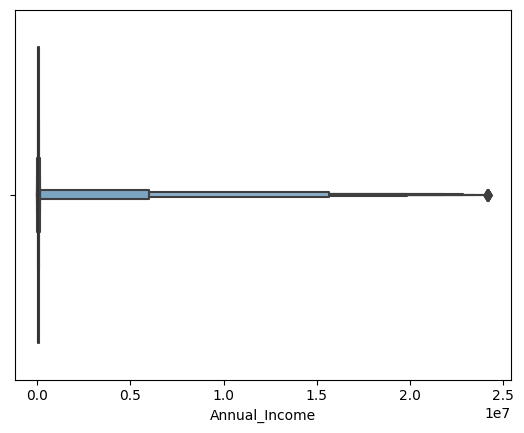

In [ ]:
sns.boxenplot(x=Clean_Data['Annual_Income'])

**Observation**

* Based on the Graph we observed that the  Annual_Income distribution is spread across different quartiles and has extreme values with power of 1e7

<Axes: xlabel='Total_EMI_per_month'>

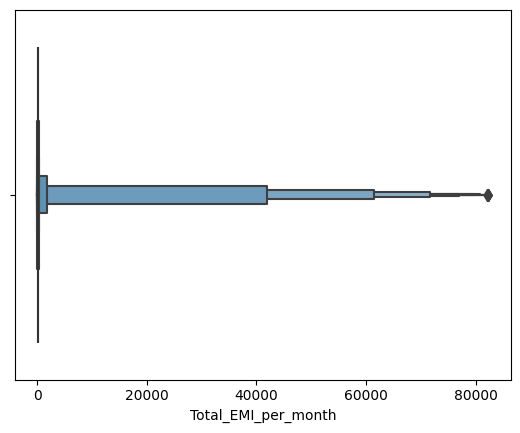

In [ ]:
sns.boxenplot(x=Clean_Data['Total_EMI_per_month'])

**Observation**

* Based on the Graph we observed that the  Total_EMI_Per_Mont distribution is spread across different quartiles and has extreme values of 8000

<Axes: ylabel='Density'>

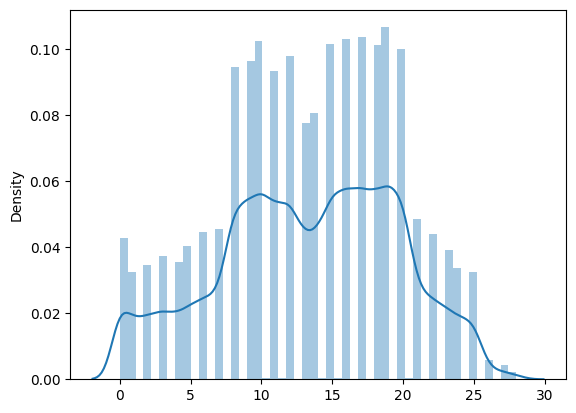

In [ ]:
sns.distplot(x=Clean_Data['Num_of_Delayed_Payment'])

**Observation**

* The above plot show that the Num_Delayed_Payment is normally Distributed

In [ ]:
Clean_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92400 entries, 0 to 92399
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Architect                  92400 non-null  int64  
 1   Developer                  92400 non-null  int64  
 2   Doctor                     92400 non-null  int64  
 3   Engineer                   92400 non-null  int64  
 4   Entrepreneur               92400 non-null  int64  
 5   Journalist                 92400 non-null  int64  
 6   Lawyer                     92400 non-null  int64  
 7   Manager                    92400 non-null  int64  
 8   Mechanic                   92400 non-null  int64  
 9   Media_Manager              92400 non-null  int64  
 10  Musician                   92400 non-null  int64  
 11  Scientist                  92400 non-null  int64  
 12  Teacher                    92400 non-null  int64  
 13  Writer                     92400 non-null  int

In [ ]:
numerical_column = [
'Annual_Income',
'Monthly_Inhand_Salary',
'Num_of_Loan',
'Delay_from_due_date',
'Num_of_Delayed_Payment',
'Outstanding_Debt',
'Credit_History_Age',
'Payment_of_Min_Amount',
'Total_EMI_per_month',
'Monthly_Balance',
'Payment_Behaviour_encoded']

categorical_column = ['Customer_ID',
'Payment_Behaviour',
'Credit_Score']

In [ ]:
numerical_data = Clean_Data[numerical_column]
categorical_data = Clean_Data[categorical_column]

In [ ]:
#Statistical Summary of Numeric Data
numerical_data.describe()

,Annual_Income,Monthly_Inhand_Salary,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Monthly_Balance,Payment_Behaviour_encoded
count,9.240000e+04,92400.000000,92400.000000,92400.000000,92400.000000,92400.000000,92400.000000,92400.000000,92400.000000,92400.000000,92400.000000
mean,1.767569e+05,4199.067540,3.528582,21.081926,13.327086,1425.550230,225.483966,0.597359,1408.948563,403.517337,2.245628
std,1.434177e+06,3188.886380,2.443213,14.858830,6.277191,1154.398294,95.970033,0.693637,8324.648660,214.745479,1.847341
min,7.005930e+03,303.645417,0.000000,0.000000,0.000000,0.230000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.943348e+04,1625.558333,2.000000,10.000000,9.000000,566.210000,154.000000,0.000000,30.291558,270.238250,0.000000
50%,3.757392e+04,3093.153333,3.000000,18.000000,14.000000,1165.670000,231.000000,0.000000,69.100853,337.186937,2.000000
75%,7.284956e+04,5967.991667,5.000000,28.000000,18.000000,1945.030000,292.000000,1.000000,160.992411,472.028710,4.000000
max,2.419806e+07,15204.633333,9.000000,67.000000,28.000000,4998.070000,404.000000,2.000000,82331.000000,1602.040519,5.000000


Text(0.5, 1.0, 'Correlation Heatmap')

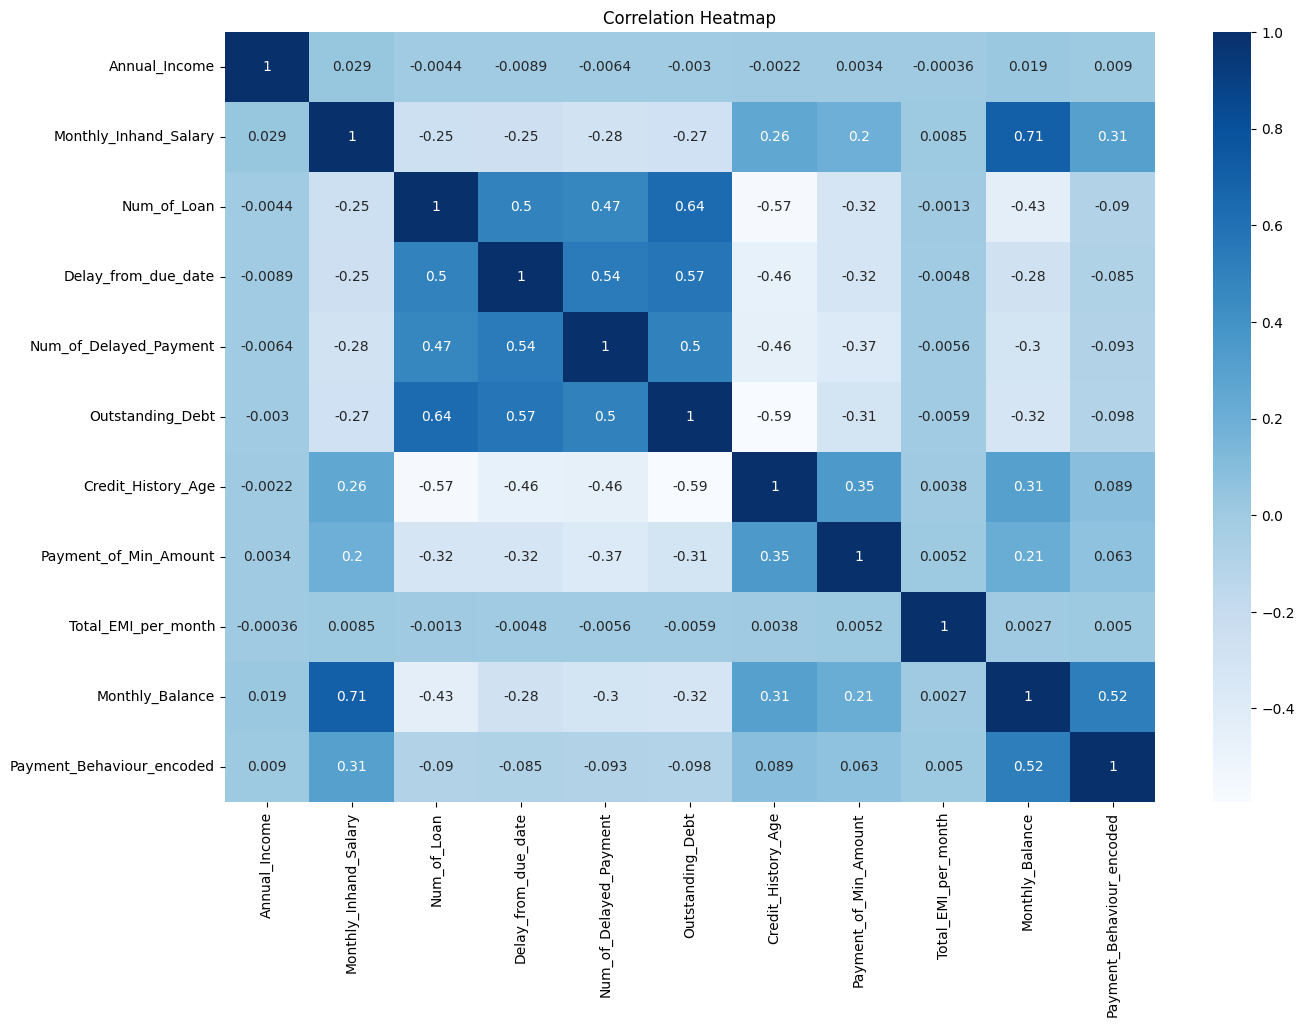

In [ ]:
fig = plt.figure(figsize = (15,10))
sns.heatmap(numerical_data.corr(method = 'pearson'), annot = True, cmap = "Blues")
plt.title("Correlation Heatmap")

**Observation**

* Based on the Overall correlation map Monthly_Inhand_Salary was highly correlated to Monthly_Balance which is with coreelation of (0.71)

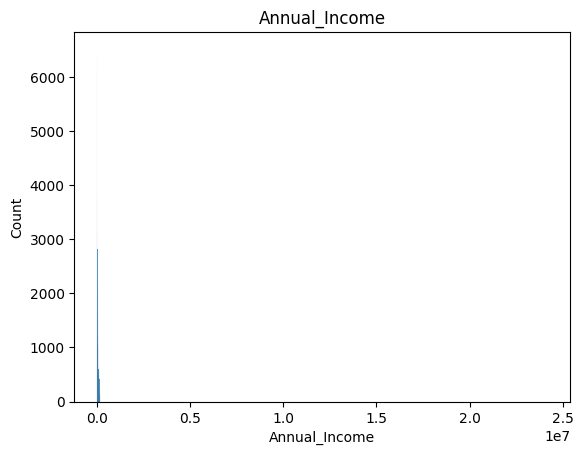

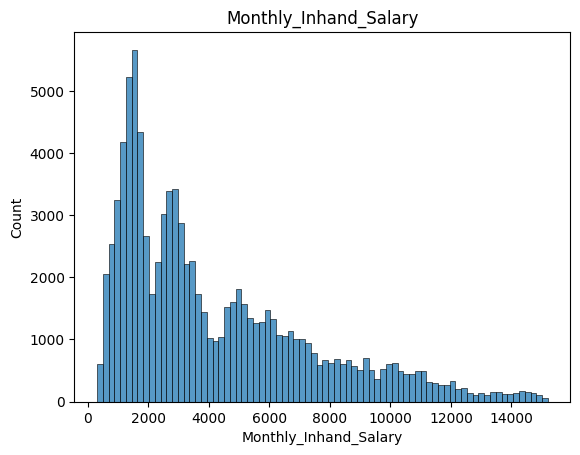

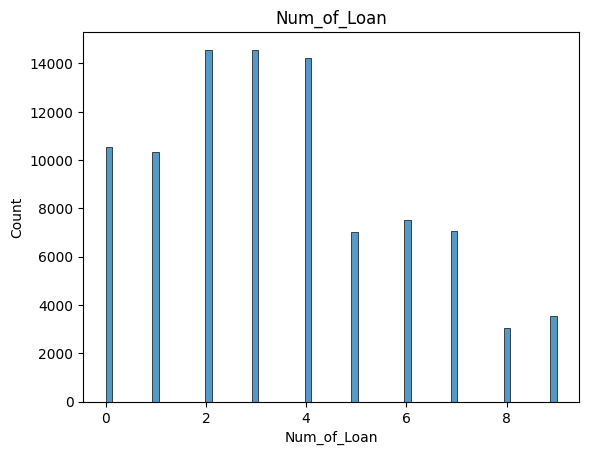

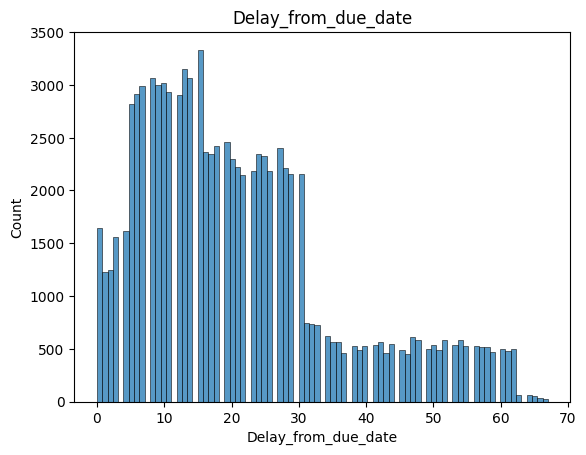

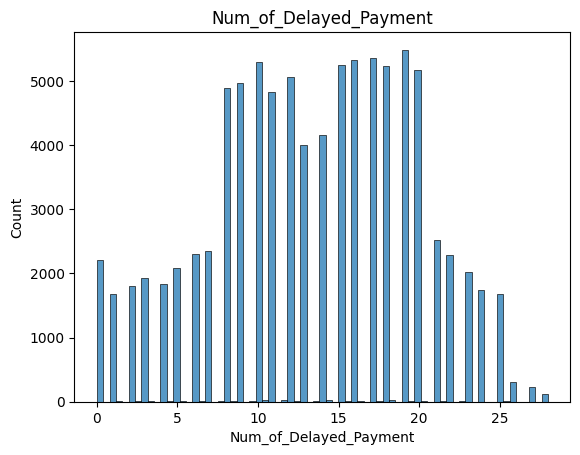

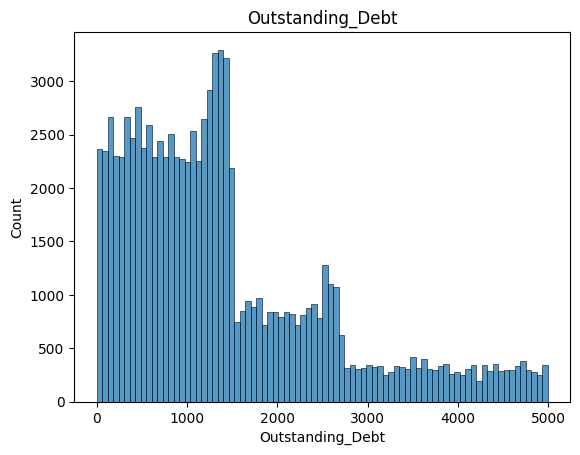

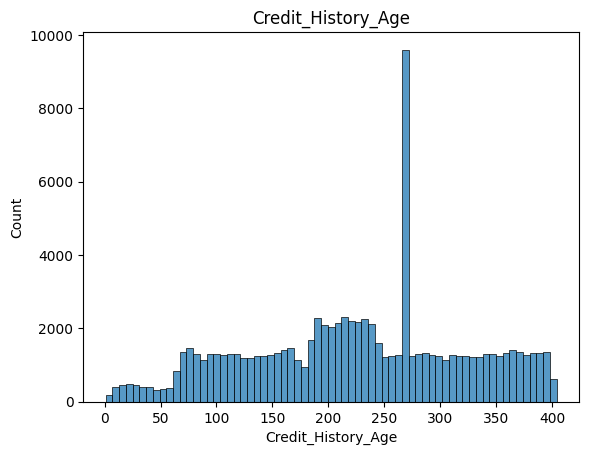

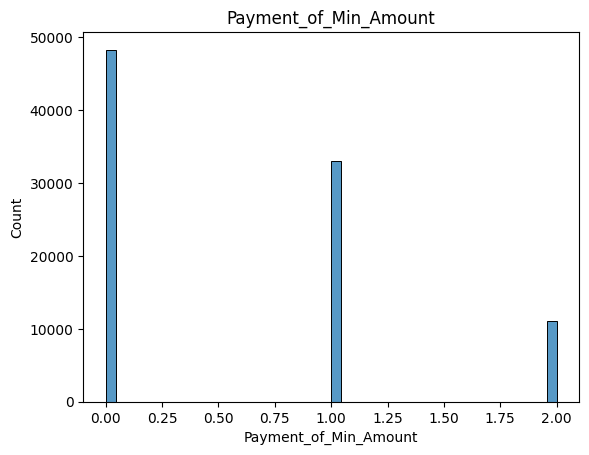

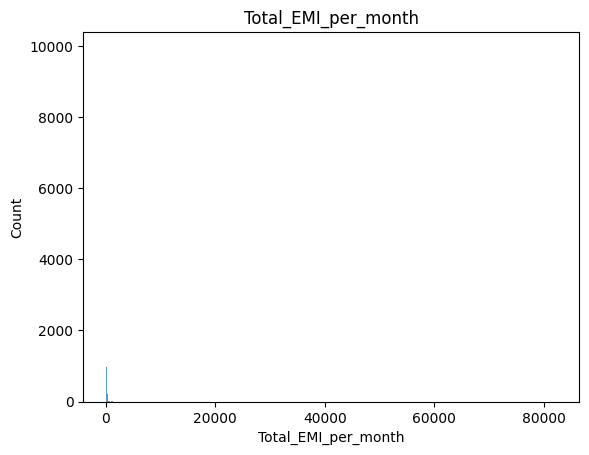

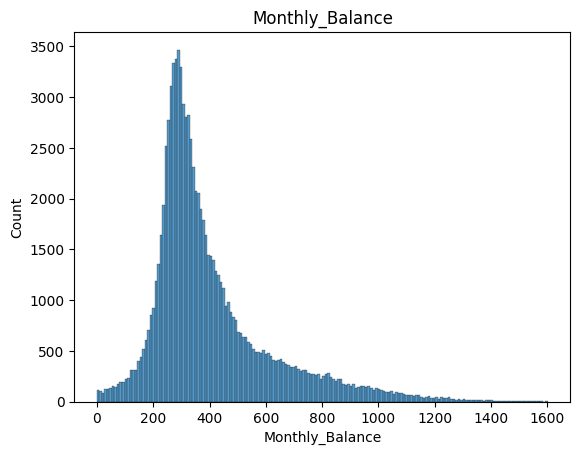

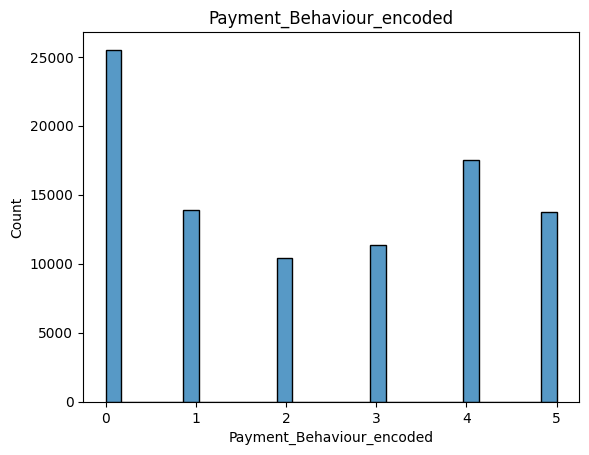

In [ ]:
#Use boxplots and histograms to check the distribution and presence of outliers.
for column in numerical_data:
    fig, hist = plt.subplots()
    plt.title(column)
    sns.histplot(numerical_data[column], ax=hist)

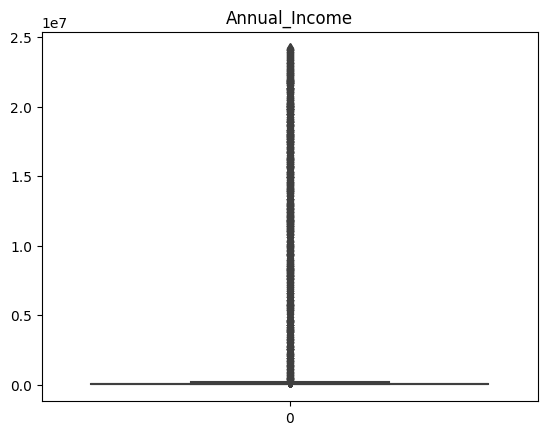

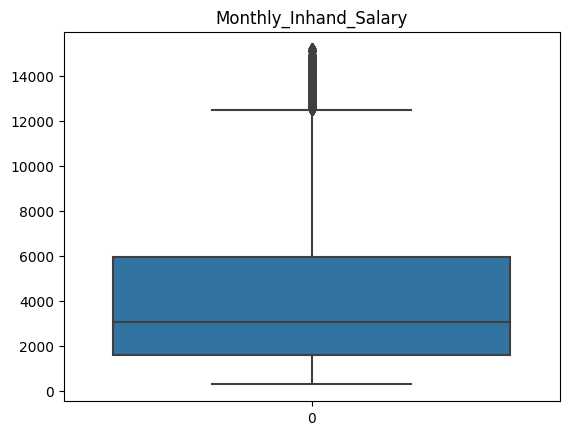

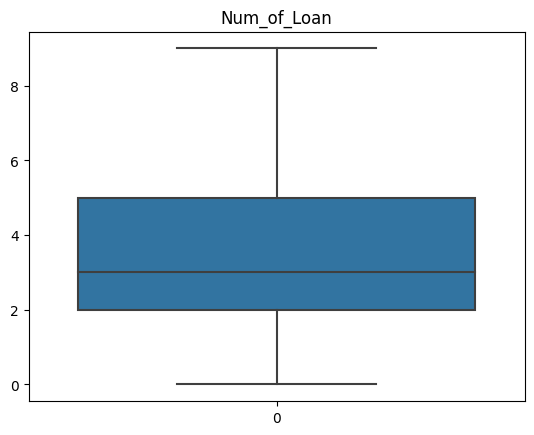

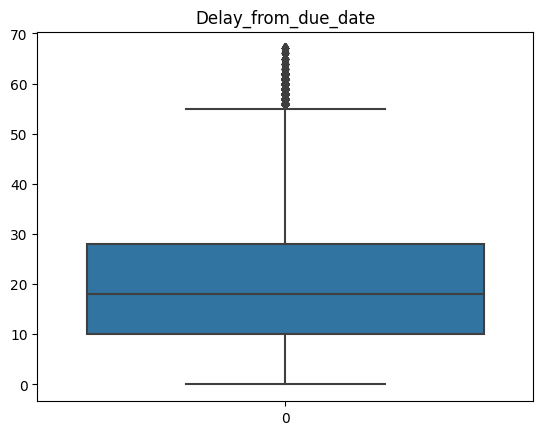

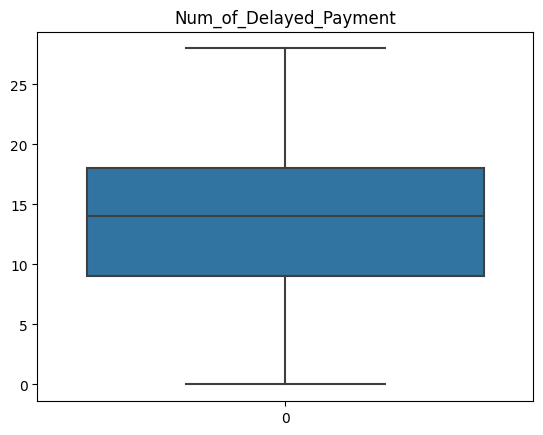

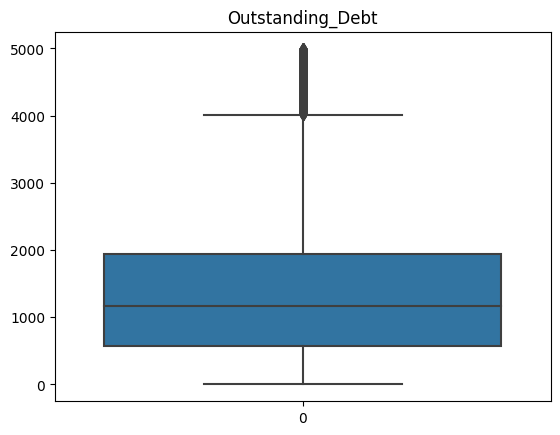

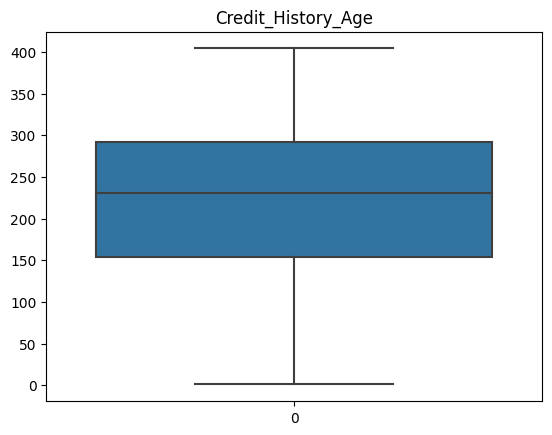

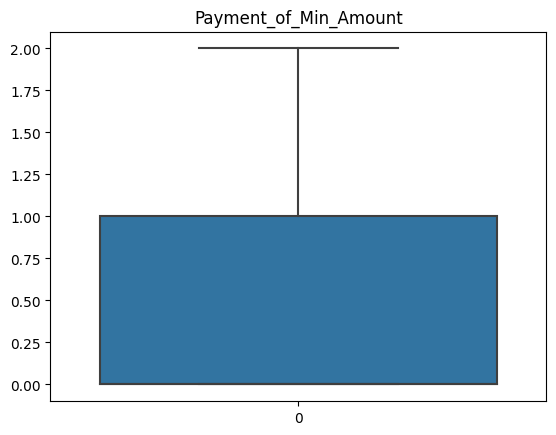

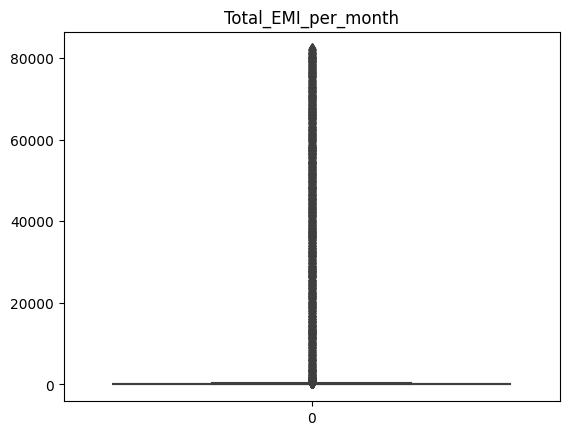

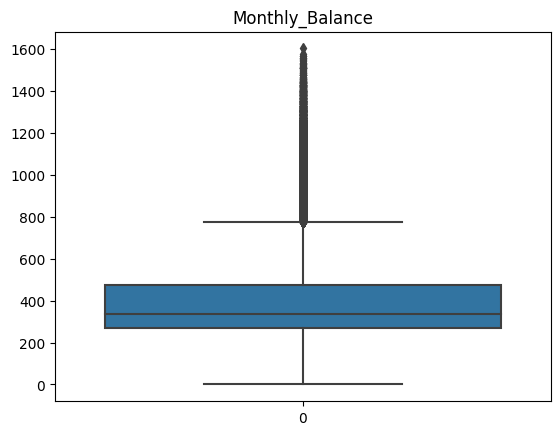

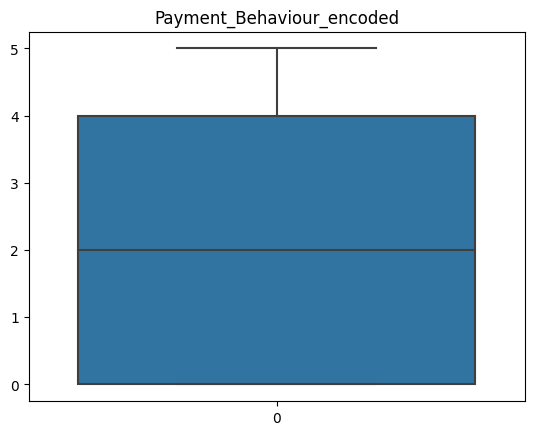

In [ ]:
for column in numerical_data:
    fig, box = plt.subplots()
    plt.title(column)
    sns.boxplot(numerical_data[column], ax=box)

**Observation**

* Based on the above plot the below are the observations
    * Monthly_Inhand_Salary is showing the data distribution is right skewed
    * Num_Of_Loan Is sparse and uniformly distributed 
    * Delay_From_Due_Date and Monthly_Balance is showing the data distribution is slightly right skewed
    * Credit_History_Age is showing the data distribution is slightly left skewed
    * Num_Delayed_Payment is normally Distributed
    * Outstanding_Debt is Highly Right Skewed data

#### 3.2 Multivariate Analysis

<Axes: xlabel='Credit_Score', ylabel='Monthly_Inhand_Salary'>

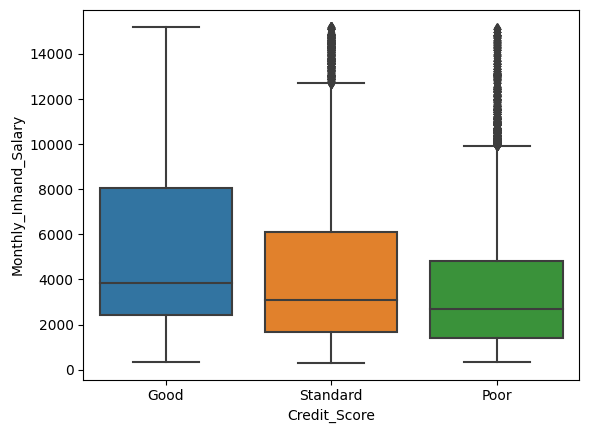

In [ ]:
sns.boxplot(data = Clean_Data, x = "Credit_Score",  y = "Monthly_Inhand_Salary")

<Axes: xlabel='Credit_Score', ylabel='Num_of_Loan'>

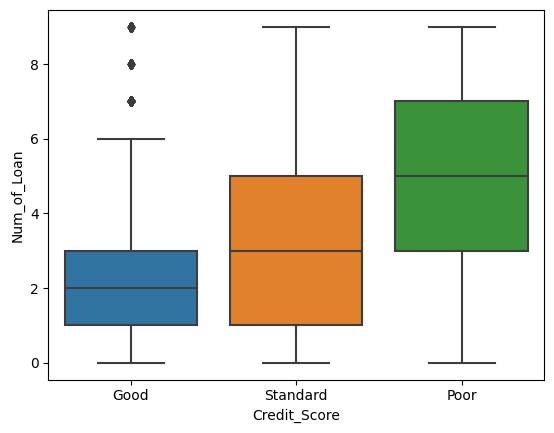

In [ ]:
sns.boxplot(data = Clean_Data, x = "Credit_Score",  y = "Num_of_Loan")

<Axes: xlabel='Credit_Score', ylabel='Annual_Income'>

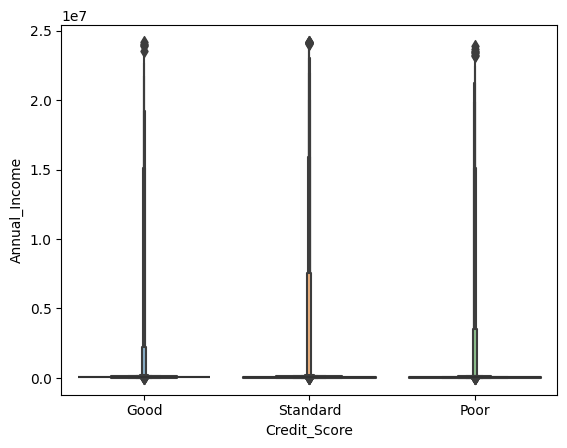

In [ ]:
sns.boxenplot(data = Clean_Data, x = "Credit_Score",  y = "Annual_Income")

<Axes: xlabel='Credit_Score', ylabel='Monthly_Balance'>

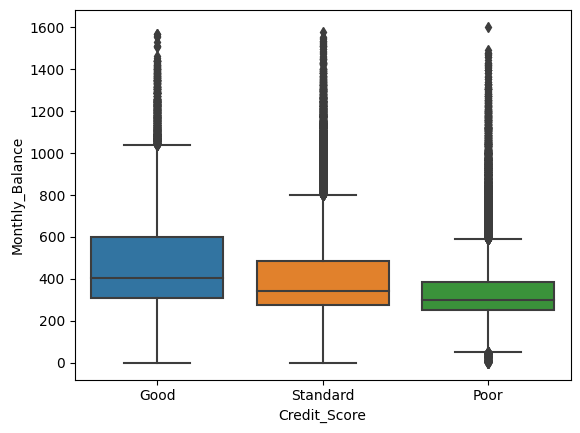

In [ ]:
sns.boxplot(data = Clean_Data, x = "Credit_Score",  y = "Monthly_Balance")

<Axes: xlabel='Credit_Score', ylabel='Payment_Behaviour_encoded'>

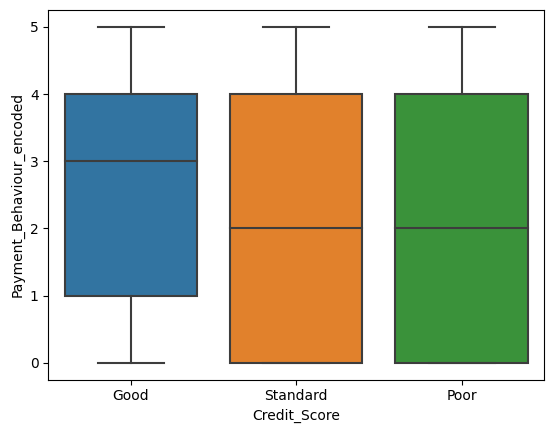

In [ ]:
sns.boxplot(data = Clean_Data, x = "Credit_Score",  y = "Payment_Behaviour_encoded")

<Axes: xlabel='Credit_Score', ylabel='Num_of_Delayed_Payment'>

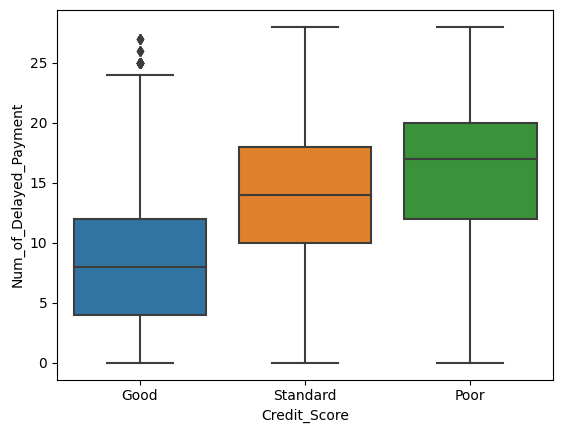

In [ ]:
sns.boxplot(data = Clean_Data, x = "Credit_Score",  y = "Num_of_Delayed_Payment")

<Axes: xlabel='Annual_Income', ylabel='Monthly_Inhand_Salary'>

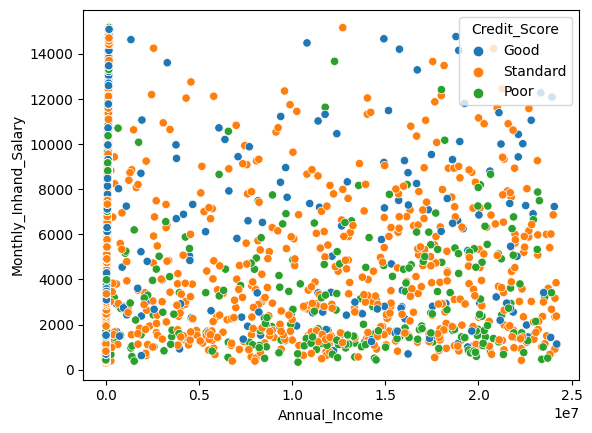

In [ ]:
sns.scatterplot (data = Clean_Data , x="Annual_Income", y = "Monthly_Inhand_Salary", hue ="Credit_Score")

<Axes: xlabel='Annual_Income', ylabel='Num_of_Loan'>

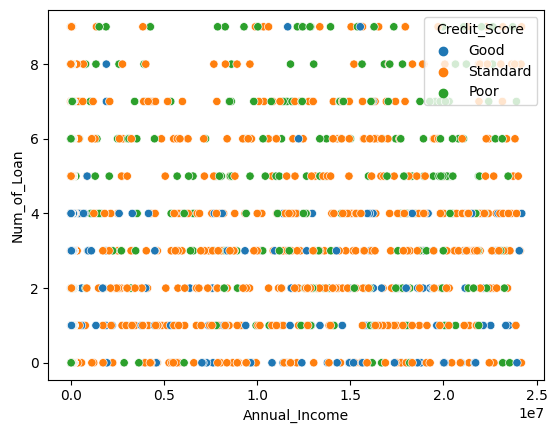

In [ ]:
sns.scatterplot (data = Clean_Data , x="Annual_Income", y = "Num_of_Loan", hue ="Credit_Score")

<Axes: xlabel='Annual_Income', ylabel='Outstanding_Debt'>

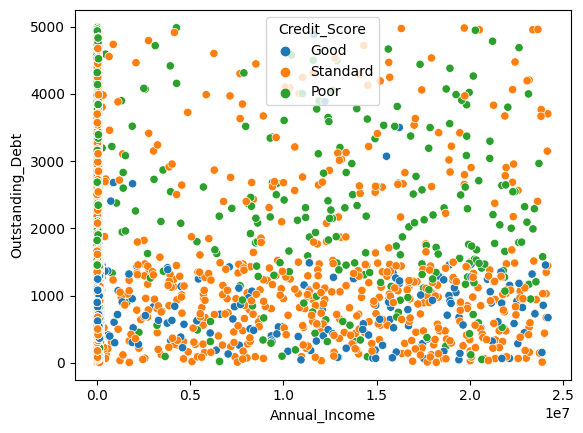

In [ ]:
sns.scatterplot (data = Clean_Data , x="Annual_Income", y = "Outstanding_Debt", hue ="Credit_Score")

<Axes: xlabel='Annual_Income', ylabel='Monthly_Balance'>

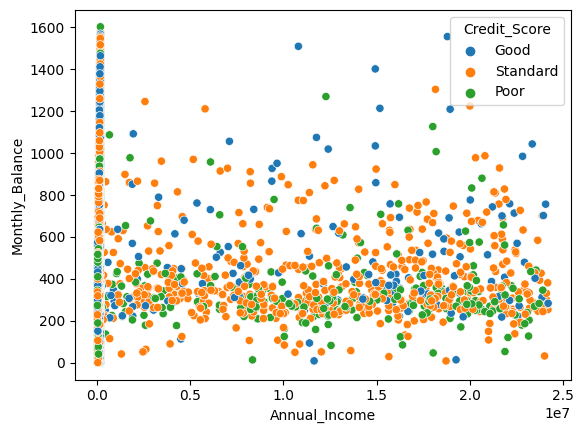

In [ ]:
sns.scatterplot (data = Clean_Data , x="Annual_Income", y = "Monthly_Balance", hue ="Credit_Score")

#### Cleaning for Modelling 

In [ ]:
#Encoding the Target value Credit_Score to numerical using Ordinal Encoding
credit_levels = ["Poor","Standard","Good"]
encoder_CS = OrdinalEncoder(categories=[credit_levels])
Clean_Data["Credit_Score"] = encoder_CS.fit_transform(Clean_Data[['Credit_Score']])
# Converting the Credit_Score column as int
Clean_Data["Credit_Score"] = Clean_Data['Credit_Score'].astype(int)

In [ ]:
# Creating the Final Dataset for the Model and dropping the Non-Value addded columns
final_dataset = Clean_Data.drop(["Payment_Behaviour", "ID", "Customer_ID"], axis=1)

In [ ]:
# Exporting the Clean and exploratory analysed data for further modelling
final_dataset.dtypes

Architect                      int64
Developer                      int64
Doctor                         int64
Engineer                       int64
Entrepreneur                   int64
Journalist                     int64
Lawyer                         int64
Manager                        int64
Mechanic                       int64
Media_Manager                  int64
Musician                       int64
Scientist                      int64
Teacher                        int64
Writer                         int64
Annual_Income                float64
Monthly_Inhand_Salary        float64
Num_of_Loan                  float64
Delay_from_due_date            int64
Num_of_Delayed_Payment       float64
Outstanding_Debt             float64
Credit_History_Age           float64
Payment_of_Min_Amount        float64
Total_EMI_per_month          float64
Monthly_Balance              float64
Credit_Score                   int64
Payment_Behaviour_encoded    float64
dtype: object

In [ ]:
final_dataset.to_csv('final_dataset.csv', index=True)

In [ ]:
dataset = pd.read_csv('final_dataset.csv')

In [ ]:
dataset.isnull().any()

Unnamed: 0                   False
Architect                    False
Developer                    False
Doctor                       False
Engineer                     False
Entrepreneur                 False
Journalist                   False
Lawyer                       False
Manager                      False
Mechanic                     False
Media_Manager                False
Musician                     False
Scientist                    False
Teacher                      False
Writer                       False
Annual_Income                False
Monthly_Inhand_Salary        False
Num_of_Loan                  False
Delay_from_due_date          False
Num_of_Delayed_Payment       False
Outstanding_Debt             False
Credit_History_Age           False
Payment_of_Min_Amount        False
Total_EMI_per_month          False
Monthly_Balance              False
Credit_Score                 False
Payment_Behaviour_encoded    False
dtype: bool

###Balancing Dataset


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
#X_train/X_test = Feature (excluding the Credit_Score)
#y_train/y_test = Target(Credit_Score)

X_train, X_test, y_train, y_test = train_test_split(final_dataset.drop('Credit_Score', axis=1), final_dataset['Credit_Score'], test_size=0.3 , random_state=42)

In [ ]:
smote = SMOTE()

In [ ]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_smote

,Architect,Developer,Doctor,Engineer,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,...,Monthly_Inhand_Salary,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Monthly_Balance,Payment_Behaviour_encoded
0,0,1,0,0,0,0,0,0,0,0,...,3228.656667,0.000000,14,6.000000,562.340000,276.000000,1.0,0.000000,467.862077,4.000000
1,0,0,0,1,0,0,0,0,0,0,...,1535.463333,6.000000,26,16.000000,2673.820000,185.000000,0.0,70.904984,320.510672,1.000000
2,0,1,0,0,0,0,0,0,0,0,...,1145.464167,6.000000,30,15.000000,3889.880000,100.000000,0.0,37.079271,290.274699,4.000000
3,0,0,0,0,0,0,0,1,0,0,...,14285.776667,0.000000,6,5.000000,932.230000,267.500000,1.0,0.000000,290.682852,1.000000
4,0,0,0,0,0,0,0,0,0,0,...,13611.203333,4.000000,6,7.000000,630.620000,258.000000,1.0,297.893363,1098.074823,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103456,0,0,0,0,0,0,0,0,0,0,...,7388.450180,1.269062,10,7.807186,198.002722,280.213173,1.0,18526.394828,795.910523,3.865469
103457,1,0,0,0,0,0,0,0,0,0,...,1646.647917,4.000000,13,8.000000,841.070000,370.336113,1.0,46.331435,293.074832,2.831944
103458,0,0,0,0,0,0,0,0,0,0,...,1414.036912,8.034806,41,21.412984,3103.595379,188.112819,0.0,76.787034,287.373787,2.965194
103459,0,0,0,0,0,0,0,0,0,0,...,2975.159077,3.411940,8,13.705970,180.395095,277.697054,1.0,87.220503,407.194974,3.588060


In [ ]:
y_train_smote

0         1
1         0
2         1
3         2
4         2
         ..
103456    2
103457    2
103458    2
103459    2
103460    2
Name: Credit_Score, Length: 103461, dtype: int64

In [ ]:
# Merging the Training Features and Target into single datafram

train_df = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame(y_train_smote)], axis = 1)

In [ ]:
train_df

,Architect,Developer,Doctor,Engineer,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,...,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Monthly_Balance,Payment_Behaviour_encoded,Credit_Score
0,0,1,0,0,0,0,0,0,0,0,...,0.000000,14,6.000000,562.340000,276.000000,1.0,0.000000,467.862077,4.000000,1
1,0,0,0,1,0,0,0,0,0,0,...,6.000000,26,16.000000,2673.820000,185.000000,0.0,70.904984,320.510672,1.000000,0
2,0,1,0,0,0,0,0,0,0,0,...,6.000000,30,15.000000,3889.880000,100.000000,0.0,37.079271,290.274699,4.000000,1
3,0,0,0,0,0,0,0,1,0,0,...,0.000000,6,5.000000,932.230000,267.500000,1.0,0.000000,290.682852,1.000000,2
4,0,0,0,0,0,0,0,0,0,0,...,4.000000,6,7.000000,630.620000,258.000000,1.0,297.893363,1098.074823,5.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103456,0,0,0,0,0,0,0,0,0,0,...,1.269062,10,7.807186,198.002722,280.213173,1.0,18526.394828,795.910523,3.865469,2
103457,1,0,0,0,0,0,0,0,0,0,...,4.000000,13,8.000000,841.070000,370.336113,1.0,46.331435,293.074832,2.831944,2
103458,0,0,0,0,0,0,0,0,0,0,...,8.034806,41,21.412984,3103.595379,188.112819,0.0,76.787034,287.373787,2.965194,2
103459,0,0,0,0,0,0,0,0,0,0,...,3.411940,8,13.705970,180.395095,277.697054,1.0,87.220503,407.194974,3.588060,2


### PCA implementation
We would using PCA inorder to reduce the dimentionality of our data given that we have so many numerical variables and this would enable us to have a better understanding of which variables influence the independent variable more and aslo facility our understanding of the dataset. 



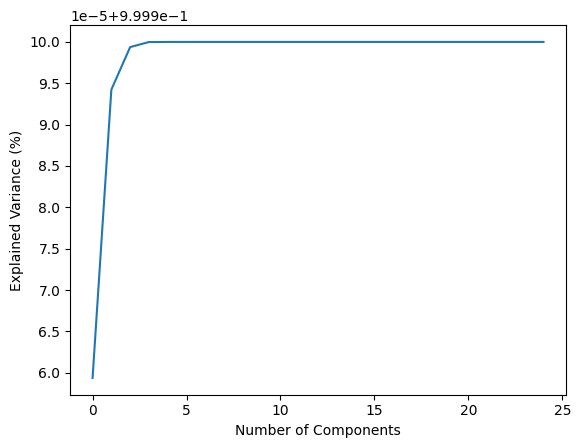

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance (%)')
plt.show()


In [ ]:
# Create PCA instance
pca = PCA(n_components=3)

# Fit and transform data
principalComponents_x_train = pca.fit_transform(X_train)
principalComponents_x_test = pca.transform(X_test)

In [ ]:
# convert result to DataFrame
pca_train = pd.DataFrame(principalComponents_x_train, columns=['PC1', 'PC2', 'PC3'])

# add original labels to new DataFrame
pca_train['Credit_Score'] = y_train

# convert result to DataFrame
pca_test = pd.DataFrame(principalComponents_x_test, columns=['PC1', 'PC2', 'PC3'])

# add original labels to new DataFrame
pca_test['Credit_Score'] = y_test

In [ ]:
pca_train

,PC1,PC2,PC3,Credit_Score
0,-135290.932442,-1413.736449,-850.242743,2.0
1,-153869.368823,-1348.917093,-2769.873047,2.0
2,-159365.387439,-1384.835539,-3292.332315,2.0
3,-1512.739137,-1388.236039,10068.759374,2.0
4,-13039.655458,-1091.524052,9470.435113,2.0
...,...,...,...,...
64675,-23770.040945,-1208.172286,8553.908487,1.0
64676,-155266.224386,-1390.627137,-2959.688375,1.0
64677,-121952.845381,-1276.769856,-139.004823,NaN
64678,-153381.698258,-1359.137441,-2534.715446,NaN


In [ ]:
pca_test

,PC1,PC2,PC3,Credit_Score
0,-153266.557774,-1357.734900,-2905.058524,NaN
1,-154537.944544,-1417.776422,-2659.141675,NaN
2,-154369.624285,-1347.029534,-2502.112292,NaN
3,-155774.777738,-1380.528601,-2972.468937,NaN
4,-153448.180606,-1308.642113,-2665.579009,NaN
...,...,...,...,...
27715,-140623.173071,-1316.053344,-1476.109646,1.0
27716,-138676.213292,-1217.597436,-1015.720212,NaN
27717,-112555.765223,-1249.294385,987.491528,0.0
27718,-155613.163290,-1390.017784,-2705.513880,NaN


In [ ]:
pca_train['Credit_Score'] = y_train

In [ ]:
#pca_train = pca_train.drop("Credit_Score", axis = 1 )
pca_train.shape

(64680, 4)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize


scaler = StandardScaler()

#fitting
cred_scaled = scaler.fit_transform(train_df)

#Normalizing our data with mean 0 and standard deviation, so it follows a normal distribution
cred_normalized = normalize(train_df)

#Dimentioonality reduction
pca = PCA(n_components=3)
cred_principal = pca.fit_transform(cred_normalized)
x_pca = cred_principal

Text(0.5, 0, 'Third Principal Component')

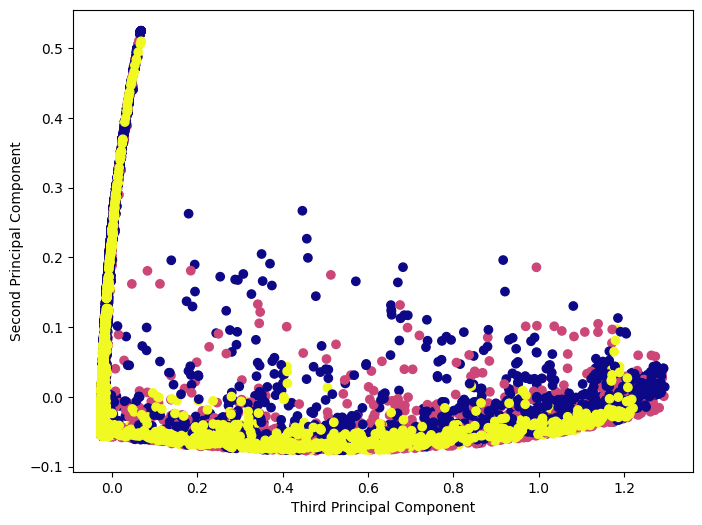

In [ ]:
# giving a larger plot
plt.figure(figsize =(8, 6))

plt.scatter(x_pca[:,0],x_pca[:, 1], c=train_df['Credit_Score'], cmap='plasma')


plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlabel('Third Principal Component')



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize


scaler = StandardScaler()

#fitting
cred_scaled = scaler.fit_transform(final_dataset_ML)

#Normalizing our data with mean 0 and standard deviation, so it follows a normal distribution
cred_normalized = normalize(cred_scaled)

#Dimentioonality reduction
pca = PCA(n_components=3)
cred_principal = pca.fit_transform(cred_normalized)
x_pca = cred_principal

In [ ]:
# giving a larger plot
plt.figure(figsize =(8, 6))

plt.scatter(x_pca[:,0],x_pca[:, 1], c=final_dataset_ML['Credit_Score'], cmap='plasma')


plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlabel('Third Principal Component')



In [ ]:
pca.components_

In [ ]:
#analyzing the results
explained_variance = pca.explained_variance_ratio_
components = pca.components_

# Print the results
for i in range(len(explained_variance)):
    print(f"Factor {i+1}: Eigenvalue = {explained_variance[i]}")
    print(f"Components: {components[i]}")

In [ ]:
final_dataset_ML.dtypes

In [ ]:
#Visualizing the variance of 
credit_comp = pd.DataFrame(pca.components_, columns=final_dataset_ML.columns)

plt.figure(figsize=(14,6))

sns.heatmap(credit_comp)

In [ ]:
cred_principal = pd.DataFrame(cred_principal)
cred_principal.columns = ['P1','P2','P3']
print(cred_principal.head())

## DBSCAN implementation

In [ ]:
from sklearn.cluster import DBSCAN

cred_clustering = DBSCAN(eps=0.0375, min_samples=10).fit(cred_principal)
labels = cred_clustering.labels_

In [ ]:
print('Shapes of cred_principal and labels:', cred_principal.shape, labels.shape)

In [ ]:
# Convert cred_principal to a NumPy array
cred_principal_arr = cred_principal.to_numpy()

# Determine unique labels and assign colors
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
color_dict = dict(zip(unique_labels, colors))

# Plot the clustered data
for label in unique_labels:
    if label == -1:
        # Plot noise points as black
        plt.scatter(cred_principal_arr[labels == label, 0], cred_principal_arr[labels == label, 1], color='k')
    else:
        plt.scatter(cred_principal_arr[labels == label, 0], cred_principal_arr[labels == label, 1], color=color_dict[label])

plt.title('Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 3')
plt.show()


In [ ]:
final_dataset_ML.to_csv('ML_dataset.csv', index=True)

## Machine Learning with PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [ ]:
spark=SparkSession.builder.master("local[*]").appName("WordCount").getOrCreate()
sc=spark.sparkContext

In [ ]:
df_cred = spark.read.csv('./ML_dataset.csv', header=True, inferSchema=True)

In [ ]:
df_cred.printSchema()

In [ ]:
pandas_data = df_cred.toPandas()

In [ ]:
df_cred.groupby("Credit_Score").count().toPandas()

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Define the number of splits for cross-validation
n_splits = 3

# Instantiate the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits)

In [ ]:
# Separate the features from the target variable
x = pandas_data.drop("Credit_Score", axis=1)
y = pandas_data['Credit_Score']

In [ ]:

def strat_split(features,target):
    for train_index, test_index in skf.split(features, target):
        # features and target for the train and test respectively
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

       # Convert from pandas back to PySpark DataFrames
        train_data = spark.createDataFrame(pd.concat([X_train, y_train], axis=1))
        test_data = spark.createDataFrame(pd.concat([X_test, y_test], axis=1))
        
        # Return the train and test datasets for each split
        return train_data, test_data

In [ ]:
train_data, test_data = strat_split(x,y)

In [ ]:
pd.DataFrame(train_data.take(5), columns = train_data.columns)

In [ ]:
train_data.groupby('Credit_Score').count().toPandas()

In [ ]:
test_data.groupby('Credit_Score').count().toPandas()